In [0]:
!pip install -U seaborn
!pip install -U pandas
!pip install -U matplotlib
!pip install -U nltk

In [0]:
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, v_measure_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

from scipy.cluster.hierarchy import dendrogram, linkage

from mpl_toolkits.mplot3d import Axes3D
# Elbow and Silhouette
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer

from nltk.cluster.kmeans import KMeansClusterer

In [0]:
ori_df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", sep=',', header=None)
df_X = ori_df.iloc[:, 0:(len(ori_df.columns) - 1)]
df_X = pd.DataFrame(StandardScaler().fit_transform(df_X))  # Standardize X
df_y = ori_df.iloc[:, len(ori_df.columns) - 1]


#Structure

1. Dimension Reduction

2. Clustering with true label (3 clusters)

3. Choose best distance method

4. Choose optimal number of clusters

# 1. Dimension Reduction

Use true label to tune some parameters of PCA and TSNE to choose which is the best for dimensions reduction for this dataset. And I use Silhouette Scoring, Elbow method as well as Hierarchical graph to do this task

a. Building PCA and TSNE

b. Silhouette Scoring

c. Elbow Method

d. Hierarchical Graph

e. Conclusion & choose best method for dimensions reduction


##a1. PCA

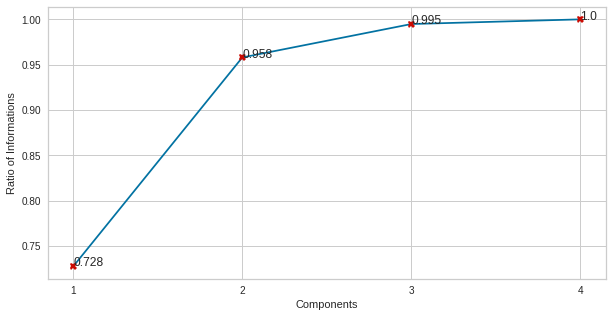

In [0]:
# PCA
pca = PCA(n_components=4).fit(df_X)

plt.figure(figsize=(10,5))
plt.plot(range(1, 5), np.cumsum(pca.explained_variance_ratio_), marker='X', markerfacecolor='r')
plt.xticks(range(1, 5))
plt.xlabel('Components')
plt.ylabel('Ratio of Informations')

axis_rw = [plt.annotate(b, (a, b)) for a, b in
           zip(range(1, 5), np.round(np.cumsum(pca.explained_variance_ratio_), 3))]
plt.show()

**Conclusion**

=> We can use 2 components with over 95.8% information

In [0]:
pca = PCA(n_components=0.95)
df_X_pca = pca.fit_transform(df_X)

df_pca = pd.DataFrame()
df_pca['label'] = df_y
df_pca['1st component'] = df_X_pca[:, 0]
df_pca['2nd component'] = df_X_pca[:, 1]

sil_pca_score = silhouette_score(X=df_X_pca, labels=df_pca['label'], metric='euclidean')

df_pca.head()

,label,1st component,2nd component
0,Iris-setosa,-2.264542,0.505704
1,Iris-setosa,-2.086426,-0.655405
2,Iris-setosa,-2.367950,-0.318477
3,Iris-setosa,-2.304197,-0.575368
4,Iris-setosa,-2.388777,0.674767


##a2. t-distributed Stochastic Neighbor Embedding.

t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples.

In [0]:
# TSNE

# Choose best perplexity
best_tsne_score = 0
best_perplexity = 0
for perplexity_current in range(1, 100, 5):
    tsne = TSNE(n_components=2, perplexity=perplexity_current)
    df_X_tsne = tsne.fit_transform(df_X)

    df_tsne = pd.DataFrame()
    df_tsne['label'] = df_y
    df_tsne['1st component'] = df_X_tsne[:, 0]
    df_tsne['2nd component'] = df_X_tsne[:, 1]
    
    sil_tsne_score = silhouette_score(X=df_X_tsne, labels=df_tsne['label'], metric='euclidean')
    if best_tsne_score < sil_tsne_score:
        best_tsne_score = sil_tsne_score
        best_perplexity = perplexity_current
print('Best perplexity no is: {0} with silhouette score {1}'
      .format(best_perplexity, best_tsne_score))

tsne = TSNE(n_components=2, perplexity=perplexity_current)
df_X_tsne = tsne.fit_transform(df_X)

df_tsne = pd.DataFrame()
df_tsne['label'] = df_y
df_tsne['1st component'] = df_X_tsne[:, 0]
df_tsne['2nd component'] = df_X_tsne[:, 1]

df_tsne.head()

Best perplexity no is: 11 with silhouette score 0.5409985184669495


,label,1st component,2nd component
0,Iris-setosa,15.252909,0.909069
1,Iris-setosa,15.737626,0.476407
2,Iris-setosa,15.470121,0.522173
3,Iris-setosa,15.582253,0.437204
4,Iris-setosa,15.148384,0.924702


##b. Silhouette

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

Text(0.5, 1.0, 'by T-SNE')

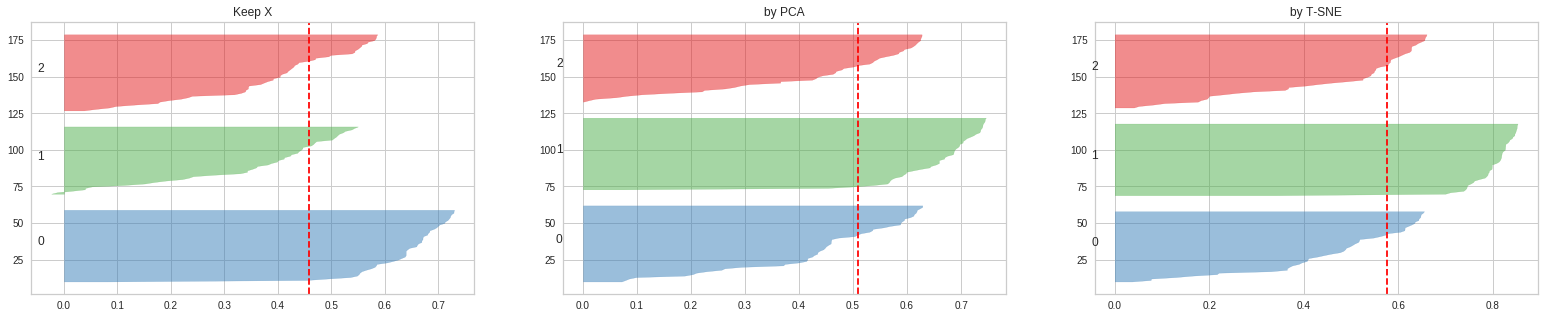

In [0]:
model = KMeans(n_clusters=3, random_state=2019, n_jobs=-1)

f, axes = plt.subplots(figsize=(27, 5), nrows=1, ncols=3)

silhousette_keep_X = SilhouetteVisualizer(model, ax=axes[0])
silhousette_keep_X = silhousette_keep_X.fit(df_X)

silhousette_pca = SilhouetteVisualizer(model, ax=axes[1])
silhousette_pca = silhousette_pca.fit(df_X_pca)

silhousette_tsne = SilhouetteVisualizer(model, ax=axes[2])
silhousette_tsne = silhousette_tsne.fit(df_X_tsne)

axes[0].set_title('Keep X')
axes[1].set_title('by PCA')
axes[2].set_title('by T-SNE')

**Conclusion**


By using Sihouette method to measure the quality of clustering. 

The T-SNE method which is also a reduction dimensions method as same as PCA gives the better answer.


##c. Elbow method

The Elbow method is a method of interpretation and validation of consistency within cluster analysis designed to help finding the appropriate number of clusters in a dataset.


Explained Variance. The "elbow" is indicated by the red circle. The number of clusters chosen should therefore be 4.
This method looks at the percentage of variance explained as a function of the number of clusters: One should choose a number of clusters so that adding another cluster doesn't give much better modeling of the data. More precisely, if one plots the percentage of variance explained by the clusters against the number of clusters, the first clusters will add much information (explain a lot of variance), but at some point the marginal gain will drop, giving an angle in the graph. The number of clusters is chosen at this point, hence the "elbow criterion". This "elbow" cannot always be unambiguously identified. Percentage of variance explained is the ratio of the between-group variance to the total variance, also known as an F-test. A slight variation of this method plots the curvature of the within group variance.

Text(0.5, 1.0, 'by T-SNE')

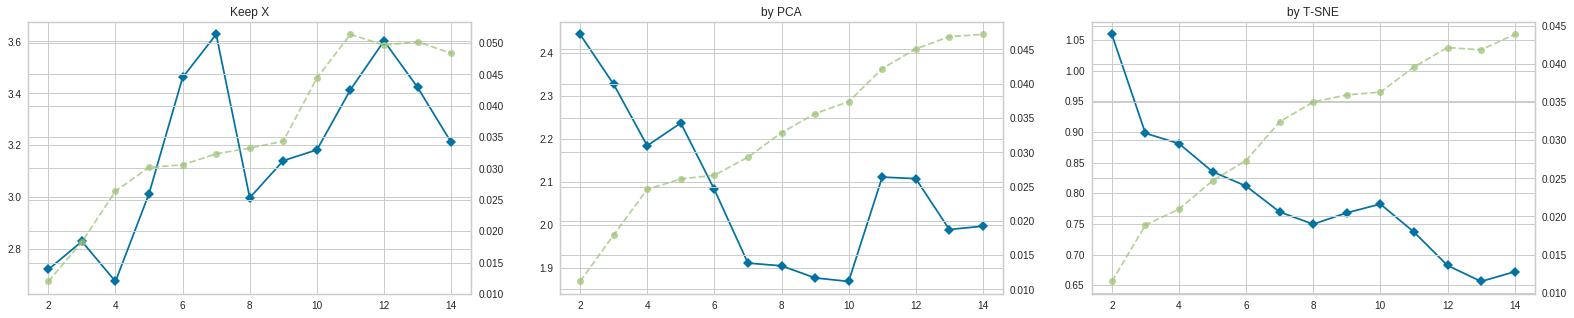

In [0]:
f, axes = plt.subplots(figsize=(27, 5), nrows=1, ncols=3)

elbow_pca = KElbowVisualizer(model, k=(2, 15), ax=axes[0])
elbow_pca.fit(df_X)

elbow_pca = KElbowVisualizer(model, k=(2, 15), ax=axes[1])
elbow_pca.fit(df_X_pca)

elbow_tsne = KElbowVisualizer(model, k=(2, 15), ax=axes[2])
elbow_tsne.fit(df_X_tsne)

axes[0].set_title('Keep X')
axes[1].set_title('by PCA')
axes[2].set_title('by T-SNE')

The Elbow shows that the gain in explained variance reduces significantly:

With Keep X: 2, 4, 8 are may good optimal number of clusters

With PCA: from 2 to 4, from 5 to 7 => optimal number of clusters could be 3, 4, 6 or 7

With T-SNE: from 2 to 3, 5 and 7 to 8 => optimal number of clusters could either 2, 3, 5, 7 or 8

=> I only get range from 2 to 11

##d. Hierarchical Method

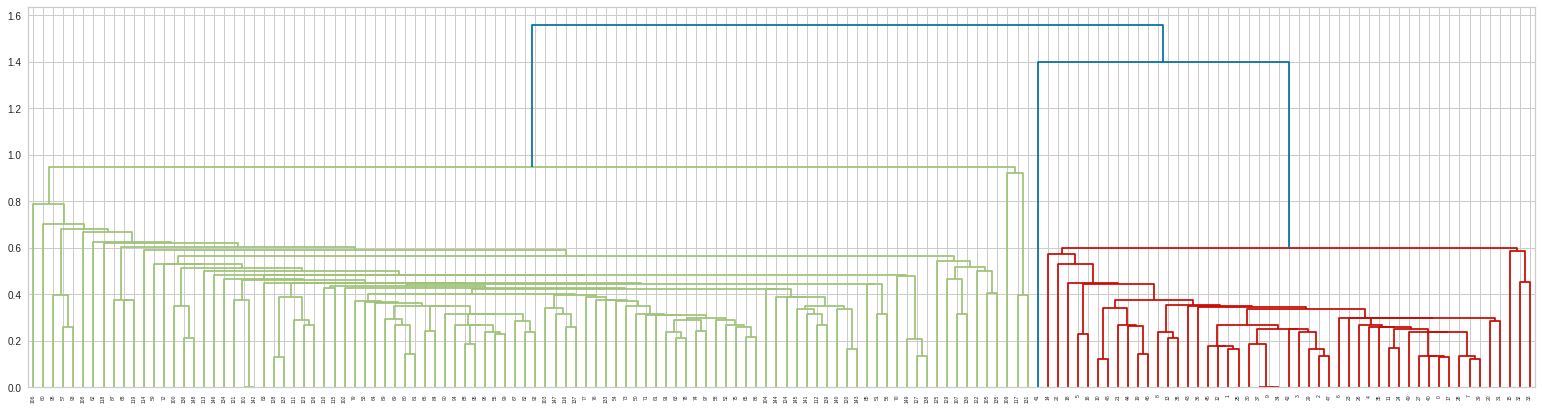

In [0]:
linked = linkage(df_X, 'single')
plt.figure(figsize=(27, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.show()  

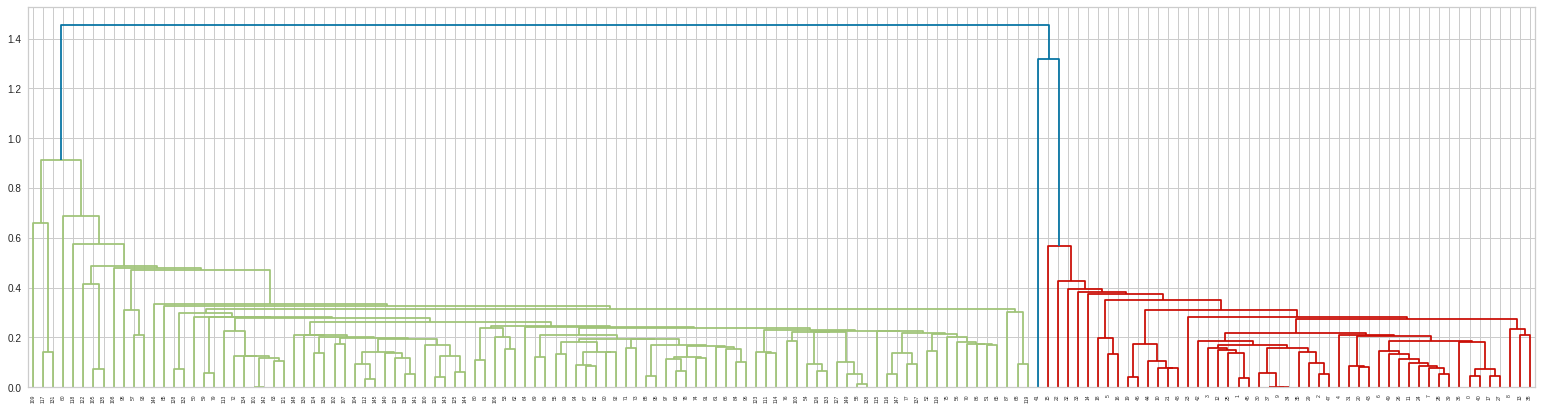

In [0]:
linked = linkage(df_X_pca, 'single')
plt.figure(figsize=(27, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.show()  

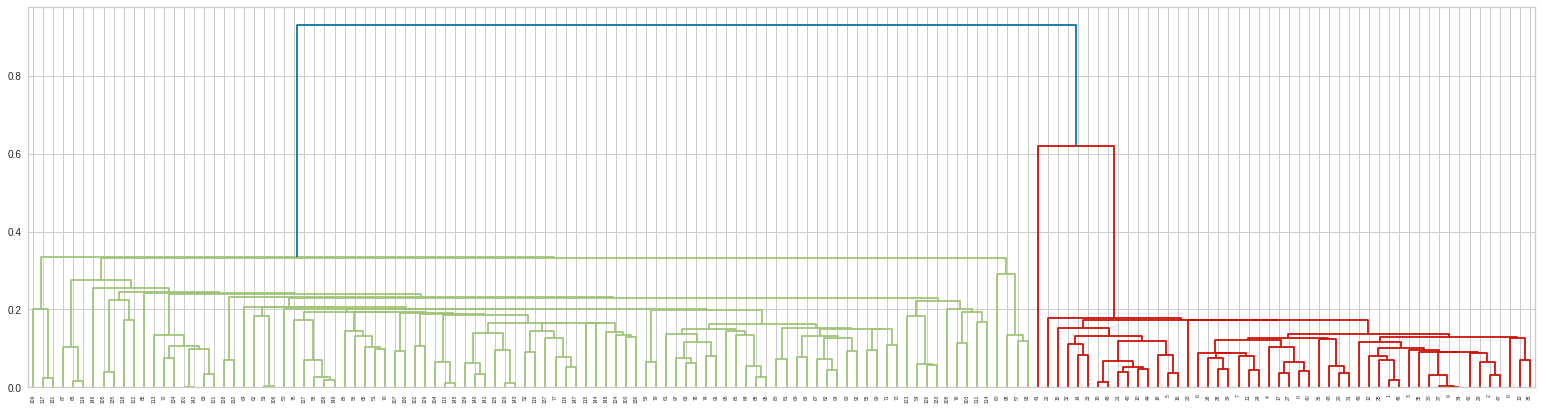

In [0]:
linked = linkage(df_X_tsne, 'single')
plt.figure(figsize=(27, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.show()  

**Conclusion**

By using Hierarchical graph, our data should be cluster lower or equal to 5 clusters. With <= 5 clusters, data still keep it information very well.

##e1. Conclusion

Based on all of above, we should cluster this problem with k equal to 2, 3, 4 or 5, because it is clear enough to see and understand.

##e2. Choose best reduction method

Sihouette Scoring of Keep X: 0.37975329261610175, PCA: 0.4002742894821798, TSNE: 0.5409985184669495 
=> We choose TSNE as our reduction method


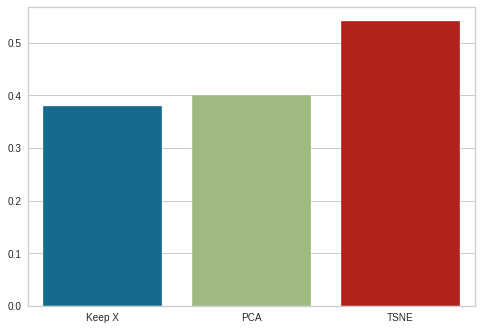

In [0]:
# Choose best reduction method and update df_X
sil_keep_X = silhouette_score(X=df_X, labels=df_y, metric='euclidean')
best_score = sil_keep_X

if sil_pca_score > best_tsne_score and best_score < sil_pca_score:
    reduction_method = "PCA"
    df = pd.DataFrame(df_pca.copy())
    # Update df_X
    df_X = pd.DataFrame() 
    df_X['1st component'] = df_X_pca[:, 0]
    df_X['2nd component'] = df_X_pca[:, 1]

elif sil_pca_score < best_tsne_score and best_score < best_tsne_score:
    reduction_method = "TSNE"
    df = pd.DataFrame(df_tsne.copy())
    # Update df_X
    df_X = pd.DataFrame() 
    df_X['1st component'] = df_X_tsne[:, 0]
    df_X['2nd component'] = df_X_tsne[:, 1]
    
print('Sihouette Scoring of Keep X: {0}, PCA: {1}, TSNE: {2} \n=> We choose {3} as our reduction method'
      .format(sil_keep_X, sil_pca_score, best_tsne_score, reduction_method))

sns.barplot(x=['Keep X', 'PCA', 'TSNE'], y=[sil_keep_X, sil_pca_score, best_tsne_score])

##e3. Cluster

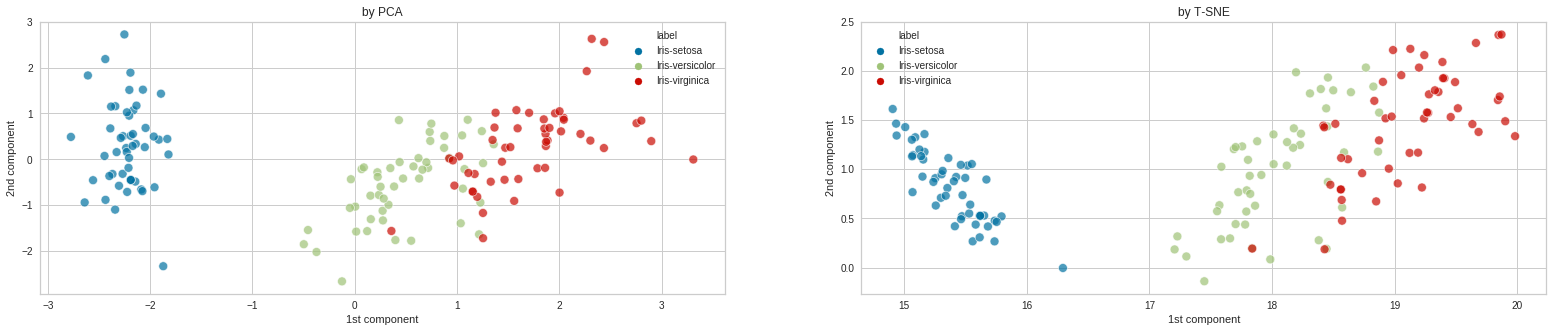

In [0]:
f, axes = plt.subplots(figsize=(27, 5), nrows=1, ncols=2)

sns.scatterplot(x='1st component', y='2nd component', hue="label", data=df_pca, 
                ax=axes[0], s=80, alpha=0.7)
sns.scatterplot(x='1st component', y='2nd component', hue="label", data=df_tsne,
                ax=axes[1], s=80, alpha=0.7)

axes[0].set_title('by PCA')
axes[1].set_title('by T-SNE')

plt.show()

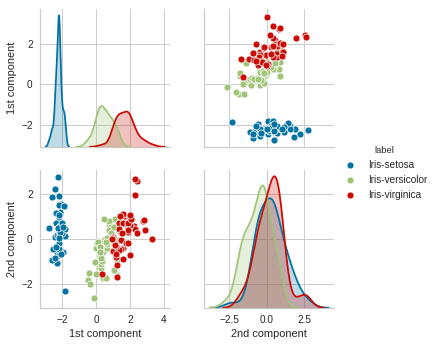

In [0]:
axes[0] = sns.pairplot(hue="label", data=df_pca)

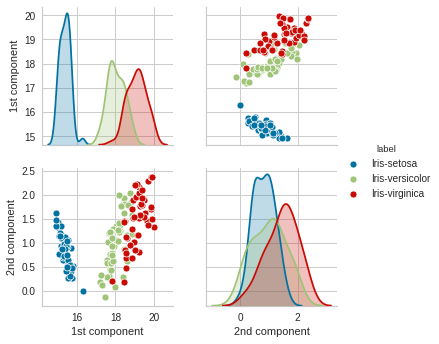

In [0]:
axes[1] = sns.pairplot(hue="label", data=df_tsne)

### By visualizing, we can see that the cluster which is generated by T-SNE is clearer than the one generated by PCA.
T-SNE gives us the intra-cluster is low and inter-cluster is high.

#2. 3 clusters with true label

a. Using KMeans and Agglemerative Clustering to cluster the data 

b. Visualize to compare the results each others.

c. Using V-measure score 

d. Conclusion


In [0]:
df.head()

,label,1st component,2nd component
0,Iris-setosa,15.252909,0.909069
1,Iris-setosa,15.737626,0.476407
2,Iris-setosa,15.470121,0.522173
3,Iris-setosa,15.582253,0.437204
4,Iris-setosa,15.148384,0.924702


In [0]:
df_X.head()

,1st component,2nd component
0,15.252909,0.909069
1,15.737626,0.476407
2,15.470121,0.522173
3,15.582253,0.437204
4,15.148384,0.924702


##a & b. KMeans & Agglomerative Clustering with True Label

In [0]:
def clustering(X, metrics, clusters):
    df_result = pd.DataFrame(X.copy())
    if metrics == 0:
        model = KMeans(n_clusters=clusters, random_state=2019, n_jobs=-1)
        df_result['label'] = model.fit(X).labels_
    else:
        model = AgglomerativeClustering(n_clusters=clusters)
        df_result['label'] = model.fit(X).labels_

    return df_result, model


In [0]:
# Build model for 3 clusters
df_kmeans_3, kmeans_model = clustering(df_X, 0, 3)
df_agg_clu_3, agg_clu_model = clustering(df_X, 1, 3)


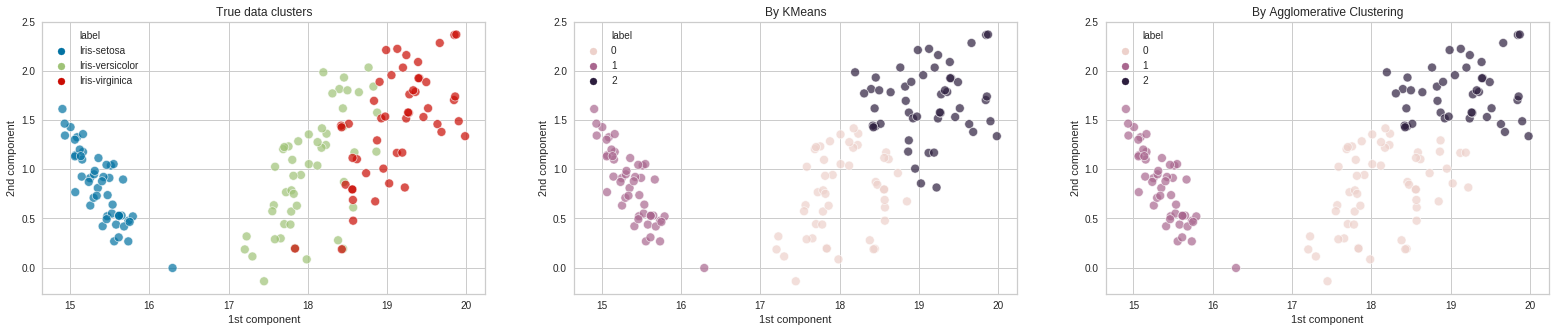

In [0]:
f, axes = plt.subplots(figsize=(27, 5), nrows=1, ncols=3)

# # Update dimension for visualizing
# df_kmeans_3['1st component'] = df['1st component']
# df_kmeans_3['2nd component'] = df['2nd component']

# df_agg_clu_3['1st component'] = df['1st component']
# df_agg_clu_3['2nd component'] = df['2nd component']

sns.scatterplot(x='1st component', y='2nd component', hue="label", data=df, 
                ax=axes[0], s=80, alpha=0.7)
sns.scatterplot(x='1st component', y='2nd component', hue="label", data=df_kmeans_3,
                ax=axes[1], s=80, alpha=0.7)
sns.scatterplot(x='1st component', y='2nd component', hue="label", data=df_agg_clu_3,
                ax=axes[2], s=80, alpha=0.7)

axes[0].set_title('True data clusters')
axes[1].set_title('By KMeans')
axes[2].set_title('By Agglomerative Clustering')

plt.show()


**Conclusion**

KMeans gives us the clusters that is the most similar to the true one comparing to Agglomerative Clustering.

But it is still intuitive so I use V-measure scoring to check back.


##c. V-measure score

V-measure cluster labeling given a ground truth.

This score is identical to normalized_mutual_info_score with the 'arithmetic' option for averaging.

The V-measure is the harmonic mean between homogeneity and completeness:

 * **v = 2 * (homogeneity * completeness) / (homogeneity + completeness)**

This metric is independent of the absolute values of the labels: a permutation of the class or cluster label values won’t change the score value in any way.

This metric is furthermore symmetric: switching label_true with label_pred will return the same score value. This can be useful to measure the agreement of two independent label assignments strategies on the same dataset when the real ground truth is not known.

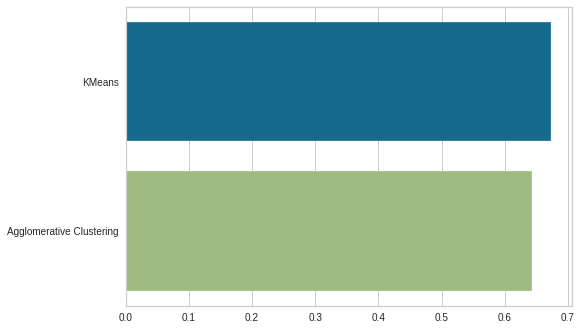

In [0]:
v_kmeans = v_measure_score(df['label'], df_kmeans_3['label'])
v_agg_clu = v_measure_score(df['label'], df_agg_clu_3['label'])

sns.barplot(y=['KMeans', 'Agglomerative Clustering'], x=[v_kmeans, v_agg_clu])

**Conclusion**

V-Measure Scoring also shows us KMeans gives the better accuracy than Agglemerative Clustering.

##d. Conclusion

I would sugggest KMeans for this problem (or this dataset)

#3. Choose best distance for 3, 5 clusters

Using KMeans to build model with 3 and 5 clusters by using 2 different distance measuring methods: Euclidean Distance and Cosine Distance.

Visualizing all data on Scatterplot for feeling.

In [0]:
kclusterer_euclid = KMeansClusterer(3, distance=nltk.cluster.util.euclidean_distance)
assigned_clusters_euclid_3 = kclusterer_euclid.cluster(df_X.values, assign_clusters=True)

kclusterer_cos = KMeansClusterer(3, distance=nltk.cluster.util.cosine_distance)
assigned_clusters_cos_3 = kclusterer_cos.cluster(df_X.values, assign_clusters=True)

kclusterer_euclid = KMeansClusterer(5, distance=nltk.cluster.util.euclidean_distance)
assigned_clusters_euclid_5 = kclusterer_euclid.cluster(df_X.values, assign_clusters=True)

kclusterer_cos = KMeansClusterer(5, distance=nltk.cluster.util.cosine_distance)
assigned_clusters_cos_5 = kclusterer_cos.cluster(df_X.values, assign_clusters=True)

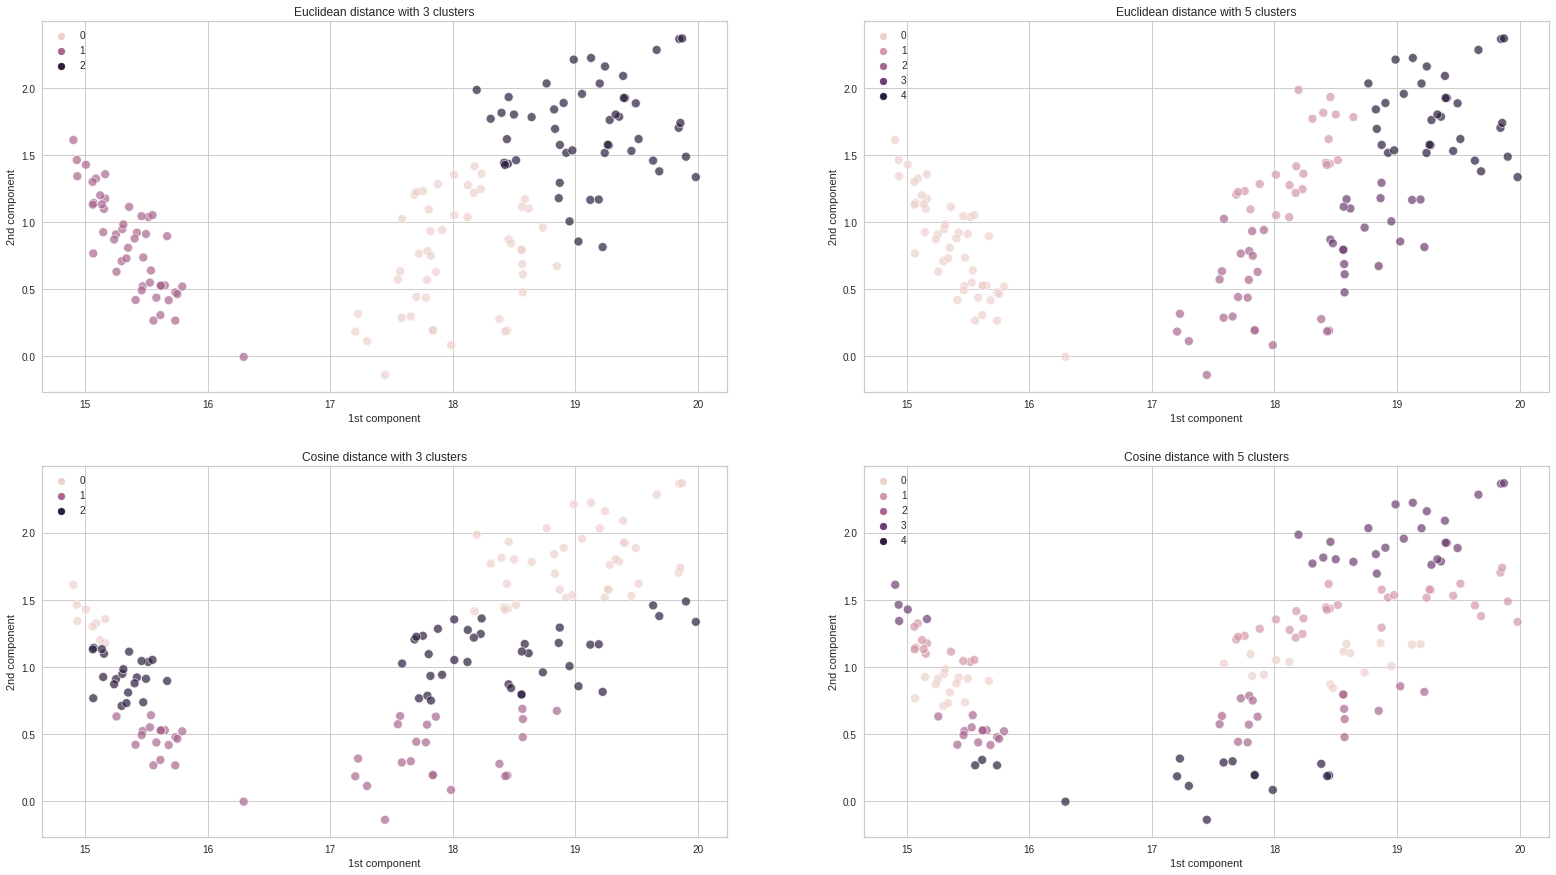

In [0]:
f, axes = plt.subplots(figsize=(27, 15), nrows=2, ncols=2)

sns.scatterplot(x='1st component', y='2nd component', hue=assigned_clusters_euclid_3,
                    data=df_X, ax=axes[0][0], s=80, alpha=0.7, legend='full')
sns.scatterplot(x='1st component', y='2nd component', hue=assigned_clusters_cos_3,
                    data=df_X, ax=axes[1][0], s=80, alpha=0.7, legend='full')

sns.scatterplot(x='1st component', y='2nd component', hue=assigned_clusters_euclid_5,
                    data=df_X, ax=axes[0][1], s=80, alpha=0.7, legend='full')
sns.scatterplot(x='1st component', y='2nd component', hue=assigned_clusters_cos_5,
                    data=df_X, ax=axes[1][1], s=80, alpha=0.7, legend='full')

axes[0][0].set_title('Euclidean distance with 3 clusters')
axes[0][1].set_title('Euclidean distance with 5 clusters')
axes[1][0].set_title('Cosine distance with 3 clusters')
axes[1][1].set_title('Cosine distance with 5 clusters')

plt.show()

##Conclusion

=> Intuitively, Euclidean distance gives us clearer clusters than Cosine distance in both 3 and 5 clusters.

#4. Choose optimal cluster numbers
a. Building KMeans & Agglomerative Clustering

b. Silhouette Scoring & Elbow Method

##a. KMeans & Agglomerative Clustering

In [0]:
# Choose best k for KMeans
kmeans_sil_score=[]
for cluster_num in range(2, 11):
    kmeans = KMeans(n_clusters=cluster_num, random_state=2019, n_jobs=-1).fit(df_X)

    kmeans_sil_score.append(silhouette_score(X=df_X, labels=kmeans.labels_, metric='euclidean'))
    print('For n_clusters={}, The Silhouette Coefficient is {}'.format(cluster_num, kmeans_sil_score[cluster_num-2]))

For n_clusters=2, The Silhouette Coefficient is 0.6972247362136841
For n_clusters=3, The Silhouette Coefficient is 0.5768768787384033
For n_clusters=4, The Silhouette Coefficient is 0.5246747136116028
For n_clusters=5, The Silhouette Coefficient is 0.4346476197242737
For n_clusters=6, The Silhouette Coefficient is 0.45465749502182007
For n_clusters=7, The Silhouette Coefficient is 0.44774138927459717
For n_clusters=8, The Silhouette Coefficient is 0.450906366109848
For n_clusters=9, The Silhouette Coefficient is 0.43757009506225586
For n_clusters=10, The Silhouette Coefficient is 0.4107365906238556


In [0]:
# Choose best k for Agglomerative Clustering
agg_clu_sil_score=[]
for cluster_num in range(2, 11):
    agg_clu = AgglomerativeClustering(n_clusters=cluster_num).fit(df_X)

    agg_clu_sil_score.append(silhouette_score(X=df_X, labels=agg_clu.labels_, metric='euclidean'))
    print('For n_clusters={}, The Silhouette Coefficient is {}'.format(cluster_num, agg_clu_sil_score[cluster_num-2]))

For n_clusters=2, The Silhouette Coefficient is 0.6972247362136841
For n_clusters=3, The Silhouette Coefficient is 0.5555649399757385
For n_clusters=4, The Silhouette Coefficient is 0.5103378295898438
For n_clusters=5, The Silhouette Coefficient is 0.5038425922393799
For n_clusters=6, The Silhouette Coefficient is 0.41727137565612793
For n_clusters=7, The Silhouette Coefficient is 0.4199356138706207
For n_clusters=8, The Silhouette Coefficient is 0.4174898564815521
For n_clusters=9, The Silhouette Coefficient is 0.4108870327472687
For n_clusters=10, The Silhouette Coefficient is 0.41146814823150635


##b. Silhouette Scoring and Elbow Method

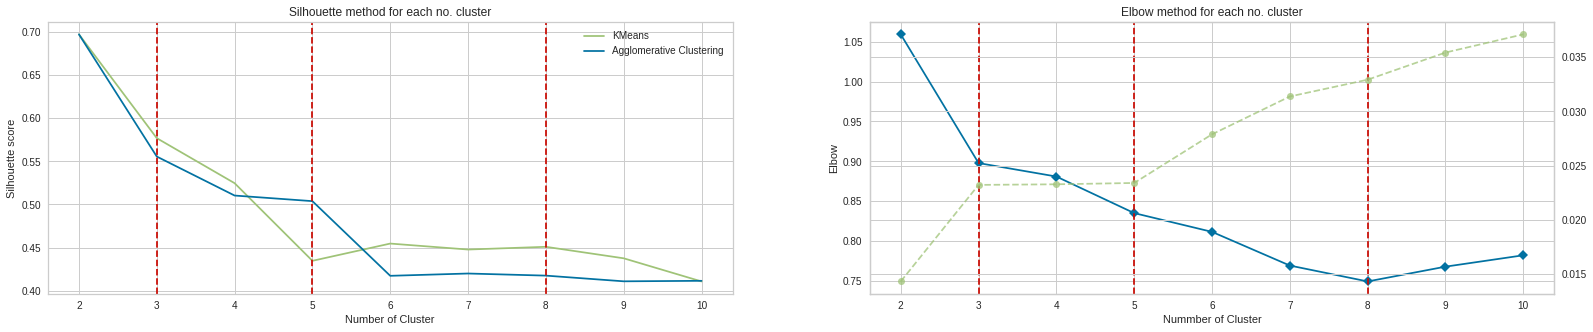

In [0]:
f, axes = plt.subplots(figsize=(27, 5), nrows=1, ncols=2)

axes[0].plot(range(2,11), kmeans_sil_score, color='g', label='KMeans')
axes[0].plot(range(2,11), agg_clu_sil_score, color='b', label='Agglomerative Clustering')

axes[0].set_xlabel('Number of Cluster')
axes[0].set_ylabel('Silhouette score')
axes[0].set_title('Silhouette method for each no. cluster')
axes[0].legend()

          
elbow_tsne = KElbowVisualizer(model, k=(2, 11), ax=axes[1])
elbow_tsne.fit(df_X_tsne)

axes[1].set_xlabel('Nummber of Cluster')
axes[1].set_ylabel('Elbow')
axes[1].set_title('Elbow method for each no. cluster')

axes[0].axvline(x=3, c='r', linestyle='--')
axes[0].axvline(x=5, c='r', linestyle='--')
axes[0].axvline(x=8, c='r', linestyle='--')
axes[1].axvline(x=3, c='r', linestyle='--')
axes[1].axvline(x=5, c='r', linestyle='--')
axes[1].axvline(x=8, c='r', linestyle='--')
plt.show()

**Conclusion**

We determine that 

Elbow method: 3, 5, 8 are kind of good number of clusters.

Silhouette method: with 3 and 5 no. clusters, KMeans can keep can score very high while Agglomerative loses at 5. 

=> We can visualize the scatterplot at 3, 5 and 7 to see the change.


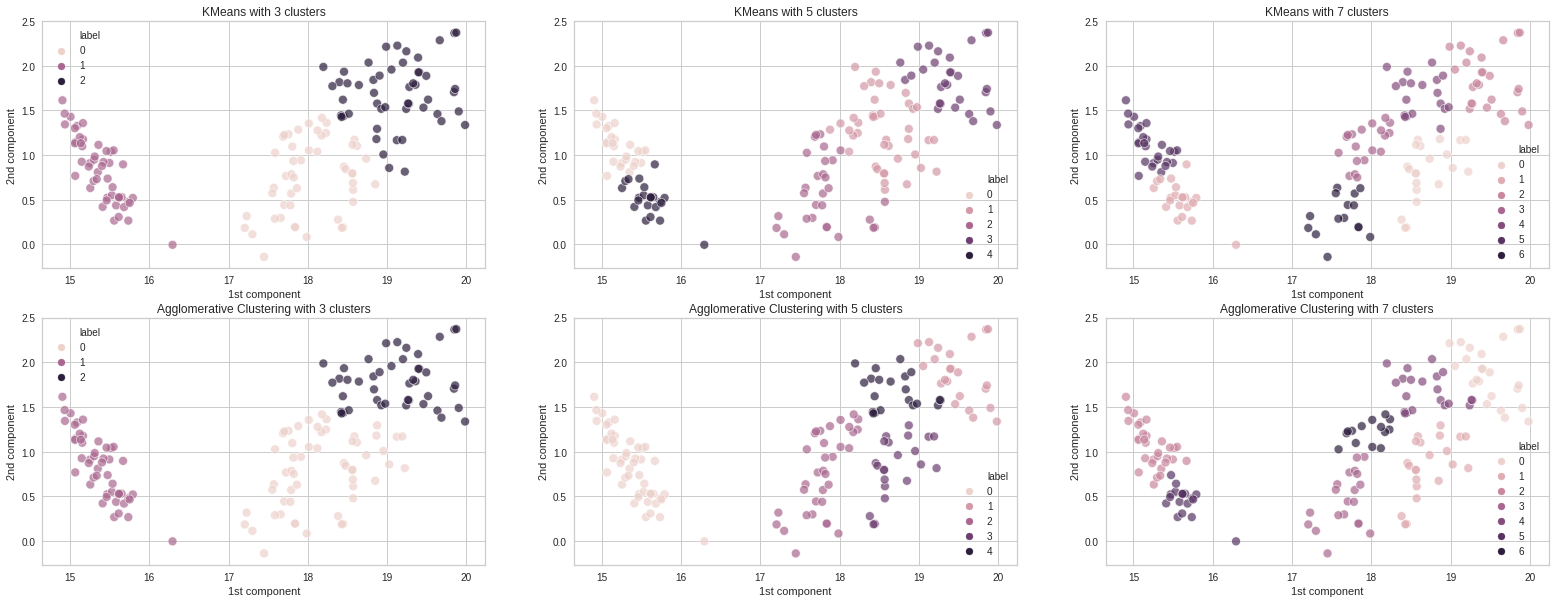

In [0]:
df_kmeans_par = {}
kmeans_model = {}
df_agg_clu_par = {}
agg_clu_model = {}

for current in range(0, 3):
    df_kmeans_par[current], kmeans_model[current] = clustering(df_X, 0, current * 2 + 3)
    df_agg_clu_par[current], agg_clu_model[current] = clustering(df_X, 1, current * 2 + 3)

# Visualize the data
f, axes = plt.subplots(figsize=(27, 10), nrows=2, ncols=3)

for current in range(0, 3):
    sns.scatterplot(x='1st component', y='2nd component', hue="label", data=df_kmeans_par[current], 
                ax=axes[0][current], s=80, alpha=0.7, legend='full')
    sns.scatterplot(x='1st component', y='2nd component', hue="label", data=df_agg_clu_par[current], 
                    ax=axes[1][current] , s=80, alpha=0.7, legend='full')

    axes[0][current].set_title('KMeans with {} clusters'.format(current*2 + 3))
    axes[1][current].set_title('Agglomerative Clustering with {} clusters'.format(current*2 + 3))

plt.show()


##d. Conclusion

We can easily figure out that:

KMeans can handle very well with 3 clusters, 5 clusters or may be 7 clusters (some noises are appeared at 7 clusters)

Agglomerative Clustering can cluster very well with 3 clusters and it looks similar to KMeans. However, with 5 clusters and 7 clusters, it solve the problem quite different to KMeans.

In conclusion, the KMeans and Agglommerative both good at 3 clusters. KMeans can keep its performance at 5 clusters or even 7 clusters on this dataset. This dataset should be split as 2, 3 or 5 clusters only

# Predict

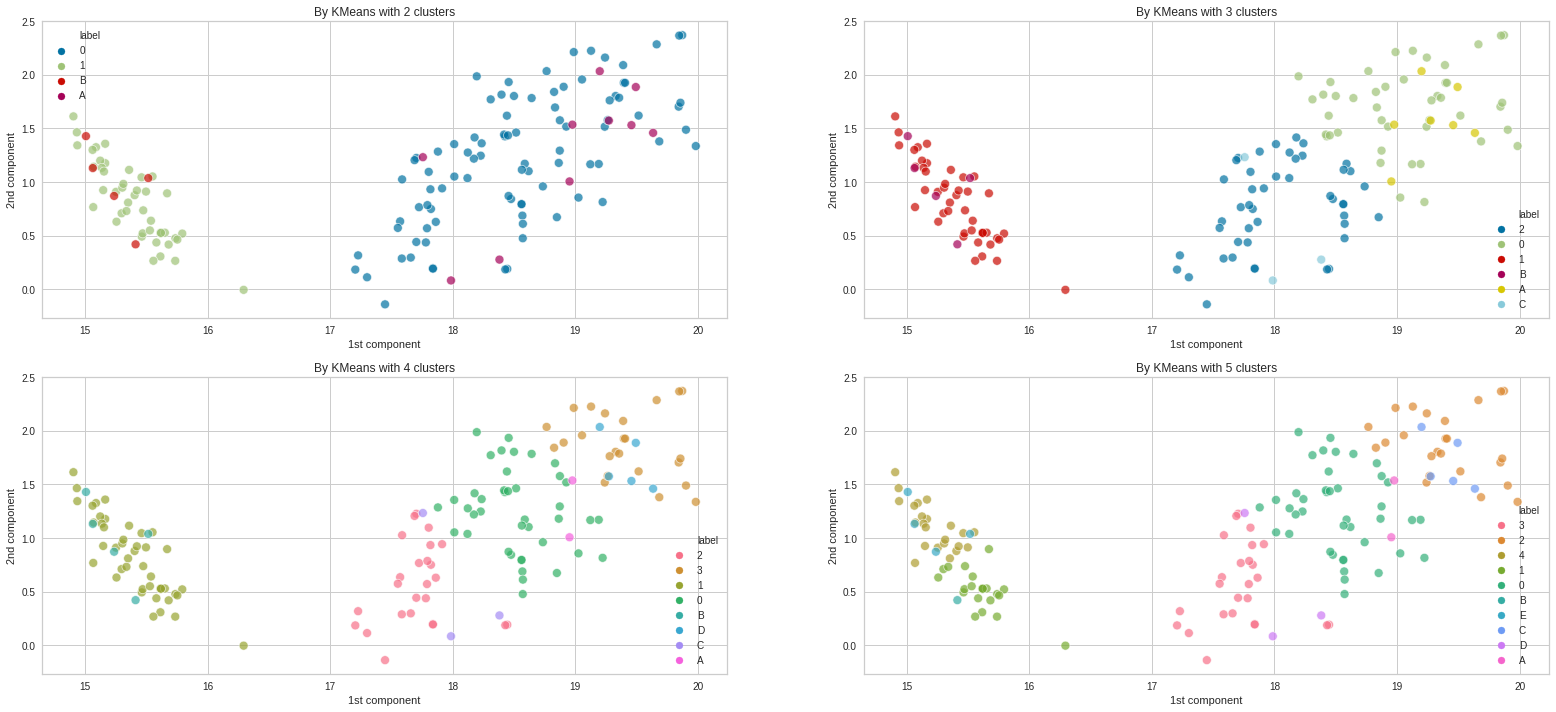

In [0]:
df_X_pre, test_X_pre = train_test_split(df_X, test_size=0.1, random_state=2019)
text_X_kmeans = pd.DataFrame(test_X_pre.copy())
test_X_agg_clu = pd.DataFrame(test_X_pre.copy())

f, axes = plt.subplots(figsize=(27, 12), nrows=2, ncols=2)
for cluster_num in [2, 3, 4, 5]:
    # Train model
    df_kmeans_pre, kmeans_model = clustering(df_X_pre, 0, cluster_num)

    #Predict
    text_X_kmeans['label'] = kmeans_model.predict(test_X_pre)
    text_X_kmeans['label'].replace(0, 'A', inplace=True)
    text_X_kmeans['label'].replace(1, 'B', inplace=True)
    text_X_kmeans['label'].replace(2, 'C', inplace=True)
    text_X_kmeans['label'].replace(3, 'D', inplace=True)
    text_X_kmeans['label'].replace(4, 'E', inplace=True)

    df_kmeans_pre = df_kmeans_pre.append(text_X_kmeans)
    # Update dimension for visualizing
    df_kmeans_pre['1st component'] = df['1st component']
    df_kmeans_pre['2nd component'] = df['2nd component']
    
    label_unique = df_kmeans_pre['label'].unique()
    
    sns.scatterplot(x='1st component', y='2nd component', hue="label", hue_order=label_unique,
                    data=df_kmeans_pre, ax=axes[round(cluster_num/2 - 0.4) - 1][cluster_num % 2], s=80, alpha=0.7)
    
    axes[round(cluster_num/2 - 0.4) - 1][cluster_num % 2].set_title('By KMeans with {0} clusters'.format(cluster_num))

plt.show()


Very good clustering algorithm